# Kaggle Digit Classification Competition
Neural Netorks using Tensorflow 2.0  
[Kaggle Digit Classification Competition Website](https://www.kaggle.com/c/digit-recognizer)  
Patrick Old

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# set some globals, which are used across the remaining functions
IMAGE_SHAPE = (28,28,1)
NUM_CLASSES = 10
# training parameters
NUM_EPOCHS = 20
BATCH_SIZE = 128

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

y_train = train_df['label']
X_train = train_df.drop('label', axis=1)
X_test = test_df

In [4]:
X_train = X_train.to_numpy().reshape(42000, 28, 28)
X_test = X_test.to_numpy().reshape(28000, 28, 28)

In [5]:
y_train = y_train.to_numpy()

### Show Image

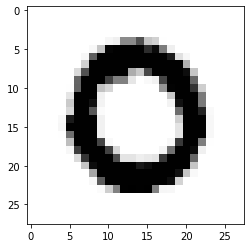

In [6]:
image_index = 1 # You may select anything up to 60,000
#print(img_names[y_train[image_index][0]]) # Print the label
plt.imshow(X_train[image_index], cmap='Greys') # Show the image

### Data Cleansing
Scaling all values to be between 0-1 for gradient descent to work properly

In [7]:
X_train = (X_train.astype('float32') / 255.0)
X_test = (X_test.astype('float32') / 255.0)

### Create Neural Network
Create an arbitrary sequential neural network that is sequential and fully connected.

In [8]:
model = Sequential()

model.add(Flatten(input_shape=[28,28])) # Change from 2-D to 1-D (28*28 neurons in input layer)

# Create Pyramid-like sequence for neural net
model.add(Dense(300, activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="tanh"))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation='softmax')) # output activation should be softmax for classication > 2 output classes

### View the Neural Network

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5

### Model Training
Previously found 20 epochs to not overfit the data too significantly, achieving ~97% accuracy on validation dataset. Retraining here with no validation dataset so the entire training dataset is used.

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=NUM_EPOCHS)

Epoch 1/20
1313/1313 [==============================] - 3s 3ms/step - loss: 0.7388 - accuracy: 0.8008
Epoch 2/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.2515 - accuracy: 0.9254
Epoch 3/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1834 - accuracy: 0.9453
Epoch 4/20
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1441 - accuracy: 0.9573
Epoch 5/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1170 - accuracy: 0.9655
Epoch 6/20
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0982 - accuracy: 0.9719
Epoch 7/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0831 - accuracy: 0.9762
Epoch 8/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0716 - accuracy: 0.9794
Epoch 9/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0623 - accuracy: 0.9822
Epoch 10/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.053

### Show Images and Predictions

Below the 10 images for the test class are shown, along with their predictions in the following cell.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


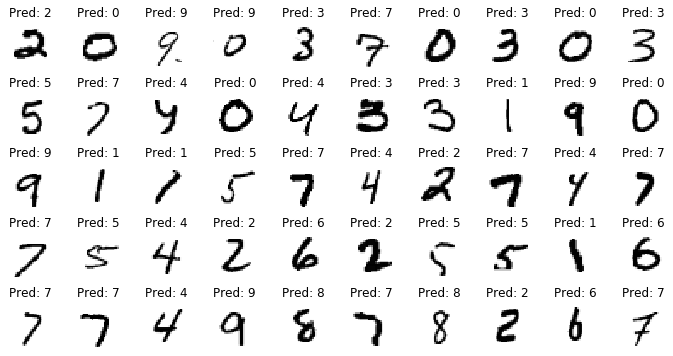

In [12]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test[index], cmap="binary", interpolation="nearest")
        pred = model.predict_classes(X_test[index:index+1])[0]
        plt.title("Pred: {}".format(pred))
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [13]:
preds = model.predict_classes(X_test)
output_dict = {"ImageId": np.arange(1, len(preds) + 1, 1), "label": preds}
preds_df = pd.DataFrame(output_dict)

In [14]:
preds_df.to_csv("mnist_dense_net.csv", index=False)

### Accuracy Evaluation
This model achieves ~97.2% accuracy when uploading the predictions on the test dataset to the Kaggle competition website. Mistakes here can be seen in the first row, fourth column of the above image. We should be able to do better than this. Next, let's try a convolutional neural network (CNN) for better accuracy.

# Convolutional Neural Network

Convolutional neural networks are excellent for computer vision tasks, and should perform better than the above fully-connected neural net with almost only dense layers. This will require a bit more pre-processing so layers such as Conv2d and Max Pooling can be used.

In [15]:
K.clear_session()

from tensorflow.keras.utils import to_categorical

print('Before preprocessing:')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}'.format(X_test.shape))

# one-hot encode labels to 10 output classes corresponding to digits 0-9
y_train = to_categorical(y_train, 10)

# reshape the image arrays (make 2D arrays instead of 3D arrays)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print('After preprocessing: ')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}'.format(X_test.shape))

Before preprocessing:
 - X_train.shape = (42000, 28, 28), y_train.shape = (42000,)
 - X_test.shape = (28000, 28, 28)
After preprocessing: 
 - X_train.shape = (42000, 28, 28, 1), y_train.shape = (42000, 10)
 - X_test.shape = (28000, 28, 28, 1)


In [16]:
def build_model():
    K.clear_session()
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
                    input_shape=IMAGE_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
                input_shape=IMAGE_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.45))
    # output is softmax for 10 classes
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

# Train The Model
I previously used a validation dataset to confirm approximate number of epochs to use. Now I will train the model using the entire training dataset and 20 epochs to ensure best accuracy for the final model.

Be sure to save the model every several epochs and check validation accuracy at each checkpoint for doing this in a more advanced way.

In [17]:
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE)

Epoch 1/20
329/329 [==============================] - 45s 137ms/step - loss: 0.4650 - acc: 0.8511
Epoch 2/20
329/329 [==============================] - 41s 123ms/step - loss: 0.1416 - acc: 0.9591
Epoch 3/20
329/329 [==============================] - 39s 120ms/step - loss: 0.1003 - acc: 0.9711
Epoch 4/20
329/329 [==============================] - 37s 113ms/step - loss: 0.0786 - acc: 0.9770
Epoch 5/20
329/329 [==============================] - 39s 117ms/step - loss: 0.0653 - acc: 0.9813
Epoch 6/20
329/329 [==============================] - 38s 116ms/step - loss: 0.0566 - acc: 0.9835
Epoch 7/20
329/329 [==============================] - 39s 117ms/step - loss: 0.0498 - acc: 0.9853
Epoch 8/20
329/329 [==============================] - 39s 117ms/step - loss: 0.0439 - acc: 0.9867
Epoch 9/20
329/329 [==============================] - 39s 117ms/step - loss: 0.0438 - acc: 0.9866
Epoch 10/20
329/329 [==============================] - 38s 116ms/step - loss: 0.0352 - acc: 0.9896
Epoch 11/20
329/329

### Show Images and Predictions

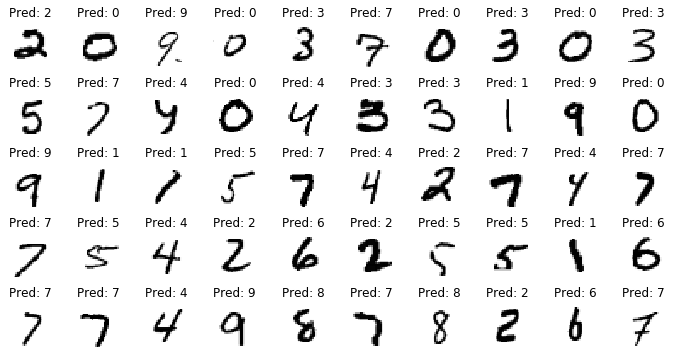

In [18]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test[index].mean(axis=2), cmap="binary", interpolation="nearest")
        pred = model.predict_classes(X_test[index:index+1])[0]
        plt.title("Pred: {}".format(pred))
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Conduct Final Predictions For Kaggle Test Set

In [19]:
preds = model.predict_classes(X_test)
output_dict = {"ImageId": np.arange(1, len(preds) + 1, 1), "label": preds}
preds_df = pd.DataFrame(output_dict)

In [20]:
preds_df.to_csv("mnist_conv_net.csv", index=False)

### Accuracy Evaluation

The convolutional neural network achieves ~99% accuracy on the Kaggle test dataset, confirmed when uploading to the competition website.